In [215]:
import torch

# Seting a seed for all
torch.manual_seed(21314)
import random
random.seed(21314)

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import os

### Data


### Loading the data from the file

In [216]:
from google.colab import drive
drive.mount('/content/drive')
data = '/content/drive/MyDrive/data_task5'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [217]:
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder

# In order to train a model in pytorch, we need to load images in the pytorch way
# Using ImageFolder to load the images
dataset = ImageFolder(data)

print("There are %d images in the data." %(len(data)))

There are 33 images in the data.


### Calculate the number of images
- Number of images in validation set (30%)
- Number of images in testing set (10%)
- Number of images in training set (60%)




In [218]:
# Calculate the number of training images, validation images and test images
num_validating = int(len(dataset)*0.3)
num_testing = int(len(dataset)*0.1)
num_trainging = len(dataset) - num_validating - num_testing
 
num_trainging, num_validating, num_testing

(1129, 563, 187)

### Create a custom dataset in order to apply image augmentation

In [219]:
import torchvision.transforms as transforms

# Creating a custom image dataset
# To apply image argumentation to each image
class DogBreedDataset(Dataset):
    def __init__(self, dataset, transformation=None):
        self.ds = dataset
        self.transformation = transformation
    
    def __len__(self):
        return len(self.ds)

    def __getitem__(self, index):
        image, label = self.ds[index]
        # If there is a transformation
        # Apply the transformation
        if self.transformation:
            image = self.transformation(image)
        return image, label

### Split the dataset and Apply the image augmentation
- Create a transformation: ```nn.sequential```
- **Only apply the transformation for the training set**
- **No transformation on testing and vadiation set**


In [220]:
# Split the Dataset to training and testing
training, validation, testing = random_split(dataset=dataset, lengths=[num_trainging, num_validating, num_testing])
# Calculat the dataset's mean and standard deviation

# TODO


# Create a sequential of transformation
transform = transforms.Compose([
    #Random Crop, the return size is 255 * 255
    transforms.Resize(size=(270, 270)),
    transforms.RandomCrop(size=224),
    # Random Horizontal Flip
    transforms.RandomHorizontalFlip(p=0.3),
    # Convert PIL.Image.Image to tensor
    transforms.RandomRotation(degrees=(-60,60)),
    transforms.ToTensor()
    #transforms.Normalize(mean=0, std=1, inplace=True)
])

testing_transform = transforms.Compose([
    # # Random Crop, the return size is 255 * 255
    transforms.Resize(size=(255,255)),
    transforms.ToTensor()
])



# Apply the transformation to datasets
training = DogBreedDataset(training, transformation=transform)
validation = DogBreedDataset(validation, transformation=testing_transform)
testing = DogBreedDataset(testing, transformation=testing_transform)

<class 'torch.Tensor'>
1


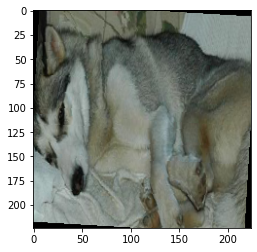

In [221]:
import matplotlib.pyplot as plt
img, label = training[6]

print(type(img))
print(label)
plt.imshow(img.permute(1,2,0))

### Dataloaders
- We want the batch size of 64
- So there are 5 batchs

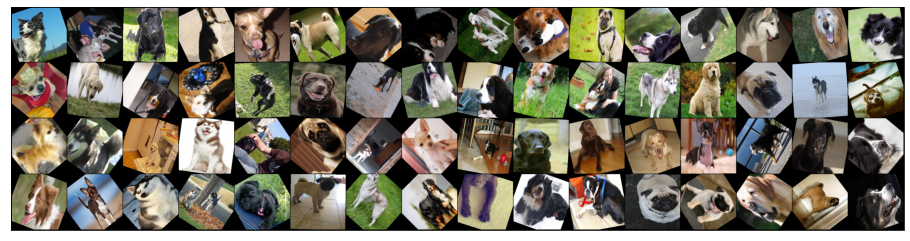

In [222]:
from torchvision.utils import make_grid
batch_size = 64

train_dl = DataLoader(dataset=training, batch_size=batch_size, shuffle=True, pin_memory=True)
val_dl = DataLoader(dataset=validation, batch_size=batch_size, pin_memory=True)
test_dl = DataLoader(dataset=testing, batch_size=batch_size, pin_memory=True)


def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break
show_batch(train_dl)

## Neural Networks

In [223]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class Net(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.network = models.resnet18(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 2),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.network(x)

### Build the CNN architecture

### Device
- Train on GPU if available

In [224]:
# Check if cuda available to run on GPU
if torch.cuda.is_available():
    device = torch.device('cuda')

# Check if apple silicon available to run on GPU
# Not working:(, many functions not implemented
# elif torch.backends.mps.is_available():
#     device = torch.device('mps')

# No GPU available, run on CPU
else:
    device = torch.device('cpu')



In [225]:
device

device(type='cuda')

### Hyperparameters
- number of epochs is 10
- learning rate is 0.0001
- number of classes is 7

In [226]:
num_epochs = 10
learning_rate = 0.001
num_class = 7

### Loss and optimizer

In [227]:
CNN_model = Net().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN_model.parameters(), lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training, Validating and Testing

In [228]:

train_accuracy = []
train_loss = []

validation_accuracy = []
validation_loss = []

test_accuracy = []

train_accuracy_by_epoch = []
train_loss_by_epoch = []
test_accuracy_by_epoch = []
validation_accuracy_by_epoch = []

SDD_test_accuracy_by_epoch = []


for epoch in range(num_epochs):

    
    # Current epoch information for printing
    curr_train_accuracy = []
    curr_train_loss = []

    curr_validation_accuracy = []
    curr_validation_loss = []

    curr_test_accuracy = []

    curr_SDD_test_accuracy = []
    
    for i, data in enumerate(train_dl, 0):
        CNN_model.train()
        inputs = data[0].to(device)
        labels = data[1].to(device)

        # Reset the optimizer, delete the gradient info from previous batch
        optimizer.zero_grad()

        # Forward pass
        outputs = CNN_model.forward(inputs)

        # Calculate the loss
        loss = loss_function(outputs, labels)
        # Backward and optimize
        loss.backward()
        optimizer.step()

        # store the current train batch loss
        train_loss.append(loss)
        curr_train_loss.append(loss)

        # store the current train batch accuracy
        correct = 0
        total = 0
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        train_accuracy.append(100*correct/total)
        curr_train_accuracy.append(100*correct/total)

    # Validation 
    CNN_model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_dl, 0):
          inputs = data[0].to(device)
          labels = data[1].to(device)

          # Predict from the model
          outputs = CNN_model(inputs)
          loss = loss_function(outputs, labels)
          validation_loss.append(loss)
          curr_validation_loss.append(loss)

          # store the current validation batch accuracy
          correct = 0
          total = 0
          _, predicted = torch.max(outputs.data, 1)
          total = labels.size(0)
          correct = (predicted == labels).sum().item()
          validation_accuracy.append(100*correct/total)
          curr_validation_accuracy.append(100*correct/total)

    # Testing
    CNN_model.eval()
    with torch.no_grad():
        for i, data in enumerate(train_dl, 0):
          inputs = data[0].to(device)
          labels = data[1].to(device)

          # Predict from the model
          outputs = CNN_model(inputs)

          # store the current validation batch accuracy
          correct = 0
          total = 0
          _, predicted = torch.max(outputs.data, 1)
          total = labels.size(0)
          correct = (predicted == labels).sum().item()
          test_accuracy.append(100*correct/total)
          curr_test_accuracy.append(100*correct/total)
    
    # # Testing on entire SDD dataset
    # CNN_model.eval()
    # with torch.no_grad():
    #     for i, data in enumerate(SDD_test_dl, 0):
    #       inputs = data[0].to(device)
    #       labels = data[1].to(device)

    #       # Predict from the model
    #       outputs = CNN_model(inputs)

    #       # store the current validation batch accuracy
    #       correct = 0
    #       total = 0
    #       _, predicted = torch.max(outputs.data, 1)
    #       total = labels.size(0)
    #       correct = (predicted == labels).sum().item()
    #       curr_SDD_test_accuracy.append(100*correct/total)

    
    curr_train_accuracy_mean = torch.mean(torch.tensor(curr_train_accuracy))
    curr_train_loss_mean = torch.mean(torch.tensor(curr_train_loss))
    curr_validation_accuracy = torch.mean(torch.tensor(curr_validation_accuracy))
    curr_test_accuracy = torch.mean(torch.tensor(curr_test_accuracy))
    curr_SDD_test_accuracy = torch.mean(torch.tensor(curr_SDD_test_accuracy))

    curr_validation_accuracy_mean = torch.mean(torch.tensor(curr_validation_accuracy))
    curr_validation_loss_mean = torch.mean(torch.tensor(curr_validation_loss))

    train_accuracy_by_epoch.append(curr_train_accuracy_mean)
    train_loss_by_epoch.append(curr_train_loss_mean)

    validation_accuracy_by_epoch.append(curr_validation_accuracy)

    test_accuracy_by_epoch.append(curr_test_accuracy)

    # SDD_test_accuracy_by_epoch.append(curr_SDD_test_accuracy)

    print("Epoch %d has training loss: %f, training accuracy: %f, validation loss: %f, validation accuracy: %f, test_accuracy: %f" %(epoch+1, curr_train_loss_mean, curr_train_accuracy_mean, curr_validation_loss_mean, curr_validation_accuracy_mean, curr_test_accuracy))
  

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 1 has training loss: 0.656613, training accuracy: 70.384483, validation loss: 1.823994, validation accuracy: 45.683552, test_accuracy: 47.730354
Epoch 2 has training loss: 0.461553, training accuracy: 77.263290, validation loss: 0.673248, validation accuracy: 66.527100, test_accuracy: 65.707573
Epoch 3 has training loss: 0.407894, training accuracy: 81.283875, validation loss: 0.752646, validation accuracy: 71.602669, test_accuracy: 75.381096
Epoch 4 has training loss: 0.367648, training accuracy: 82.721466, validation loss: 0.544013, validation accuracy: 74.210236, test_accuracy: 78.836388
Epoch 5 has training loss: 0.366655, training accuracy: 83.919800, validation loss: 0.455178, validation accuracy: 82.369965, test_accuracy: 84.197159
Epoch 6 has training loss: 0.320436, training accuracy: 86.214859, validation loss: 0.601170, validation accuracy: 80.153862, test_accuracy: 74.513039
Epoch 7 has training loss: 0.356135, training accuracy: 84.044716, validation loss: 0.518825, 

ValueError: ignored

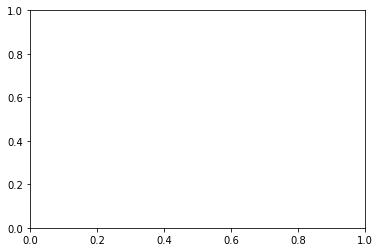

In [229]:
  plt.plot(range(290), train_accuracy)

In [ ]:
# Copy the tensor to the CPU
train_loss = torch.tensor(train_loss, device = 'cpu')
train_accuracy = torch.tensor(train_accuracy, device='cpu')

plt.plot(range(290), train_loss)

In [ ]:
validation_loss = torch.tensor(validation_loss, device = 'cpu')
test_accuracy = torch.tensor(test_accuracy, device='cpu')

plt.plot(range(290), test_accuracy)

In [ ]:
plt.plot(range(60), validation_loss)

### Drawing the graph

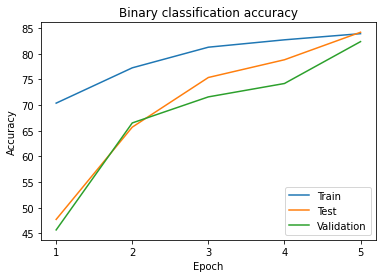

In [240]:
plt.plot([1,2,3,4,5],train_accuracy_by_epoch[0:5], label="Train")
plt.plot([1,2,3,4,5],test_accuracy_by_epoch[0:5], label="Test")
plt.plot([1,2,3,4,5],validation_accuracy_by_epoch[0:5], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1,6))
plt.legend()
plt.title("Binary classification accuracy")
plt.savefig('ResNet18_pretained', dpi = 500)
plt.show()

In [ ]:
plt.plot(range(10),SDD_test_accuracy_by_epoch, label="SDD (whole dataset) Test")
plt.plot(range(10),test_accuracy_by_epoch, label="DBI Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Testing accuracy with ResNet18")
plt.savefig('ResNet18_DBI_SDD_pretained', dpi = 500)
plt.show()

In [ ]:
print(SDD_test_accuracy_by_epoch)
print(test_accuracy_by_epoch)

In [ ]:
# Saved results
resnet18_SDD_acc = [86.3782, 87.5801, 91.9071, 89.9840, 90.3846, 90.3846, 90.0641, 87.5000, 86.6987, 86.7788]
resnet18_DBI_acc = [96.9500, 98.2000, 99.5000, 100.,99.5000, 99.7500, 100., 100., 98.2500,100.]

resnet34_SDD_acc = [91.4263, 90.2244, 88.2212, 87.9808, 84.1346, 84.6154, 84.9359, 87.4199, 89.2628, 89.9840]
resnet34_DBI_acc = [98., 99.5000, 99.2500, 98.7500, 100., 99.5000, 100., 100., 100., 100.]

resNext_SDD_acc = [90.8654, 82.9327, 80.4487, 84.0545, 87.9808, 83.8942, 85.0962, 88.0609, 79.2468, 84.6154]
resNext_DBI_acc = [98.7500, 99., 99., 98.7500, 100., 99.2500, 99.7500, 99.7500, 96.7500, 99.7500]

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
plt.plot(range(10),resnet18_SDD_acc, label="resnet18 SDD")
plt.plot(range(10),resnet34_SDD_acc, label="resnet34 SDD")
plt.plot(range(10),resNext_SDD_acc, label="resNext32 SDD")
plt.ylim([0, 100])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("three_nets_DBI", dpi=300)
plt.show()

In [ ]:
plt.plot(range(10),resnet18_DBI_acc, label="resnet18 DBI")
plt.plot(range(10),resnet34_DBI_acc, label="resnet34 DBI")
plt.plot(range(10),resNext_DBI_acc, label="resNext32 DBI")
plt.ylim([0, 100])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("three_nets_SDD", dpi=300)
plt.show()

In [ ]:
class_correct = [0. for i in range(10)]
class_total = [0. for i in range(10)]
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = CNN_model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
#         print(predicted == labels)
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %d : %2d %%' % (i, 100 * class_correct[i] / class_total[i]))